# Proglearn: Scene Segmentation
*Neuro Data Design I: Fall 2021*


This tutorial provides a walkthrough to applying a Random Forest model based on scikit image to perform scene segmentation on the ADE20K image dataset. 


**Contributors**
- Narayani Wagle (nwagle1@jhu.edu)
- Amy van Ee (avanee1@jhu.edu)

## I. Preprocessing of Images

*Accredited to Narayani Wagle*

In this first section, we will import our images from the ADE20K dataset.

In [2]:
#========================================================#
# retrieve data

import numpy as np
import cv2
import os
import zipfile
import matplotlib.pyplot as plt
from functions.scene_segmentation_rf_tutorial_functions import load_images, get_dice

# get zipped file downloaded from ADE20K
path_to_zipfile = 'C:/Users/Amy/Documents/Python/Neuro Data Design/ADE20K_2017_05_30_consistency.zip'

# unzip
directory_to_extract_to = './'
with zipfile.ZipFile(path_to_zipfile, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

# location of data
dataloc = 'C:/Users/Amy/Documents/Python/Neuro Data Design/'

# extract images
datadir = dataloc + 'ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/'
imgkeys = [im.split('_seg')[0] for im in os.listdir(datadir) if '_seg' in im]
lblpaths = [datadir+im for im in os.listdir(datadir) if '_seg' in im]
imgpaths = [datadir+im for im in os.listdir(datadir) if '.jpg' in im and im.split('.jpg')[0] in imgkeys]

# sort and print information
imgpaths.sort()
lblpaths.sort()
print('Total # of images =', len(imgpaths))
print('Total # of labels =', len(lblpaths))
imgpaths[:5], lblpaths[:5]

Total # of images = 64
Total # of labels = 64


(['C:/Users/Amy/Documents/Python/Neuro Data Design/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001001.jpg',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001005.jpg',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001015.jpg',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001034.jpg',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001054.jpg'],
 ['C:/Users/Amy/Documents/Python/Neuro Data Design/ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001001_seg.png',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/ADE20K_2017_05_30_consistency/images/consistencyanalysis/origi

We will know visualize a few sample images.

In [ ]:
#========================================================#
# VIEW SAMPLES
fig, ax = plt.subplots(5,2)
for i in range(5):
    img = cv2.imread(imgpaths[i])
    lbl = cv2.imread(lblpaths[i]) 
    ax[i][0].imshow(img)
    ax[i][0].axis('off')
    ax[i][1].imshow(lbl)
    ax[i][1].axis('off')
plt.show()

In [ ]:
#========================================================#
# view image and label shape
print('Image size: ', img.shape, ', Label size: ', lbl.shape)

We next define a function to flatten the images, as this may help in training our Random Forest and Neural Network models in the future when using Proglearn to ensure the correct dimensionality.

In [ ]:
#========================================================#
# load images

# boolean to indicate flattening of images
flatten_imgs = False

# tuple for target dimensions of image
dim = (64,64) 

# load images as X and Y
X, Y = load_images(dim, flatten_imgs)
print(X.shape, X[0].shape)

**Labels Analysis**

Here we examine what colors in the labelled segmentation images mean.

In [ ]:
#========================================================#
# set this to the dimensions you want the images to be
colors_per_img = np.array([[-1,-1,-1]])
for img in Y:
    unique_colors_per_img = np.unique(img.reshape(-1, img[0].shape[1]), axis=0)
    colors_per_img = np.vstack((colors_per_img, unique_colors_per_img))

In [ ]:
#========================================================#
# identify unique (R,G,B) 3-tuples per image
colors = np.unique(colors_per_img[1:,:], axis=0)
print('Unique Colors in 64x64 images =', colors.shape[0])

In [ ]:
#========================================================#
# identify unique colors in entire dataset
color_img = dict()

for color in colors:
    for img in Y:
        if color in img:
            ctup = (color[0], color[1], color[2])
            try:
                numimgs = color_img[ctup]
                color_img[ctup] = numimgs + 1
            except:
                color_img[ctup] = 1

In [ ]:
#========================================================#
# identify how many colors (labels) are present only in 1 image (unique colors) and how many colors (labels) are not unique to objects
nonuniquelabels = 0
for c in color_img.keys():
    if color_img[c] > 1:
        nonuniquelabels += 1
print('Total colors = ', len(color_img))
print('Non-unique colors =', nonuniquelabels)

**Re-Map Labels**

We discovered in the analysis section that the segmentations are the colors corresponding to the labels, NOT labels themselves. This means that color labels are only relative to the image itself, not the dataset. For example, a tree in image 1 can be pink and a human in image 2 can be pink, but a tree in image 3 is not necessarily pink. We predict models might be performing a more unsupervised approach for dealing with this dataset.

The following attempt below is to map each color value in the segmentations to an integer label in order to simplify model training.

In [ ]:
#========================================================#
# assign each color an int label
for i, c in zip(range(len(color_img)), color_img.keys()):
    color_img[c] = i

In [ ]:
#========================================================#
# loop through labels in dataset and change RGB pixel values into the integer label they map to
for k in range(Y.shape[0]):
    lbl = Y[k]
    for j in range(lbl.shape[0]):
        dim1 = lbl[j]
        for i in range(dim1.shape[0]):
            color = dim1[i]
            ctup = (color[0], color[1], color[2])
            try:
                dim1[i] = color_img[ctup]
            except:
                print('Fail')
        lbl[j] = dim1
    Y[k] = lbl     

In [ ]:
#========================================================#
# VIEW HISTOGRAM SHOWING TOTAL NUMBER OF CLASSES ON x-AXIS - corresponds to pixels
plt.hist(lbl.flatten())
plt.show()

## II. Scene Segmentation: Scikit-Image

*This section is accredited to Amy van Ee*

To test other methods of scene segmentation before we attempt an implementation of ProgLearn, we will use scikit-image. 

**Visualize an Example Image**

We will choose the image of a palm tree on a beach from the ADE20K dataset to confirm that this method works.

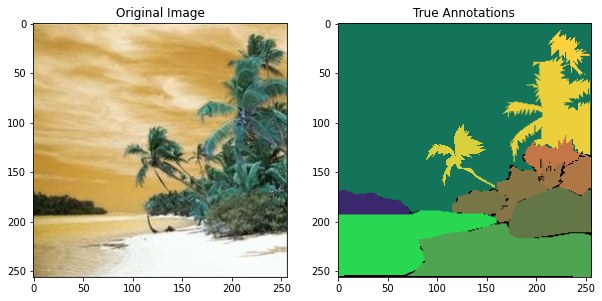

In [3]:
#========================================================#
# Plot the original image alongside the annotated image

# set up figure 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,10)

# read in images
image = cv2.imread(imgpaths[9])
label = cv2.imread(lblpaths[9]) 

# show original image in left panel
ax[0].imshow(image)
ax[0].set_title("Original Image")

# show annotated image on right panel
ax[1].imshow(label)
ax[1].set_title("True Annotations")
plt.show()

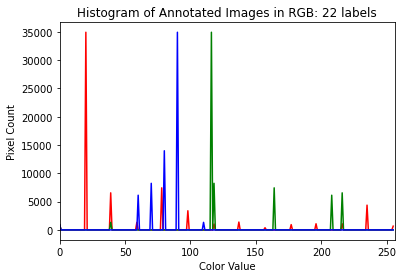

In [4]:
#========================================================#
# Show a histogram of the image

# tuple to select colors of each channel line
colors = ("red", "green", "blue")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        label[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

# label plot
plt.xlabel("Color Value")
plt.ylabel("Pixel Count")
plt.title("Histogram of Annotated Images in RGB: %d labels" %(np.unique(label).size))

# show plot
plt.show()

**Visualize the Greyscale of the Image**

Although the annotated image from the ADE20K dataset has three color channels (RGB) as shown in the histogram above, scikit-image produces an annotated image that has only one. Therefore, in using the provided functions in this package, we will convert to greyscale.

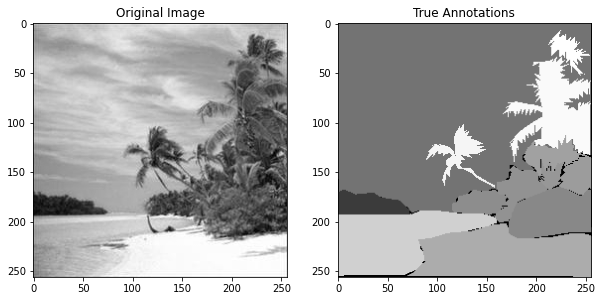

In [5]:
#========================================================#
# Convert to greyscale

from skimage.color import rgb2gray

# convert original and labeled images to be grey
image_grey = rgb2gray(image)
label_grey = rgb2gray(label)
label_grey = label_grey * 1000
label_grey = label_grey.astype(int)

# create figure
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,10)

# show original greyscale image on left
ax[0].imshow(image_grey, cmap = plt.cm.gray)
ax[0].set_title("Original Image")

# show labeled greyscale image on right
ax[1].imshow(label_grey, cmap = plt.cm.gray)
ax[1].set_title("True Annotations")

# show plot
plt.show()

Text(0, 0.5, 'Pixel Count')

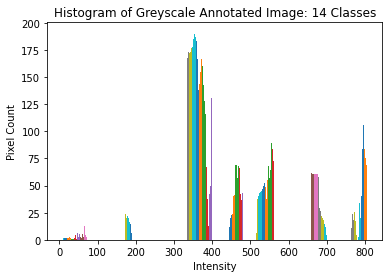

In [6]:
#========================================================#
# Show a histogram of the grey-scale image

# plot histogram 
plt.hist(label_grey)

# label axes
plt.title("Histogram of Greyscale Annotated Image: %d Classes" %(np.unique(label_grey).size))
plt.xlabel("Intensity")
plt.ylabel("Pixel Count")

**Performing the Image Segmentation**

After this prepration and analysis of the images, we will now attempt to perform scene segmentation.

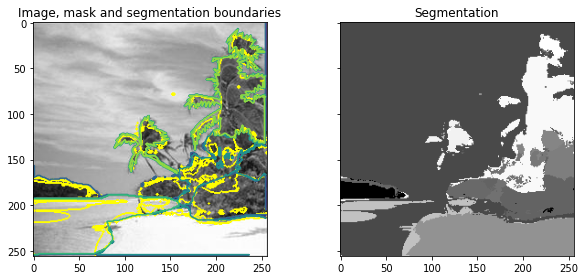

In [8]:
#========================================================#
# Use scikit-image to perform Image Segmentation

# import packages
from skimage import segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

# prepare parameters for scikit-image
sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        multichannel=True)

# obtain features from image
features = features_func(image_grey)

# define random forest
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05)

# fit forest to features from original image and labeled image
clf = future.fit_segmenter(label_grey, features, clf)

# predict labels after training
result = future.predict_segmenter(features, clf)

# plot results 
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(image_grey, result, mode='thick'))
ax[0].contour(label_grey)
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result, cmap = plt.cm.gray)
ax[1].set_title('Segmentation')
fig.tight_layout()

**Analyzing Accuracy**

We will next analyze the performance of scikit-image by computing the accuracy. We will do so by comparing the result from scene segmentation and the true annotated image.

Adapted Rand error: 0.18644213646152585
Adapted Rand precision: 0.9420672471418936
Adapted Rand recall: 0.7159003801164245
False Splits: 0.5293584404585733
False Merges: 0.9911335294007754
Dice Coefficient: 0.828704833984375


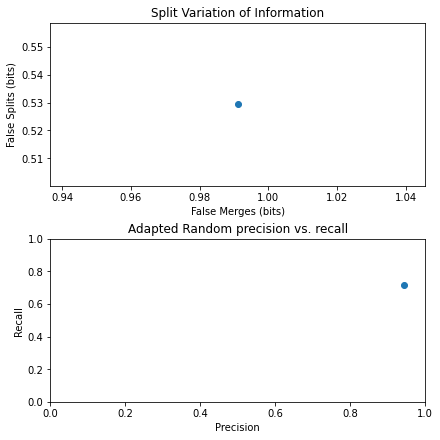

In [10]:
#========================================================#
# Analyze the accuracy by looking at 
# precision, recall, false splits, false merges, dice score

from skimage.metrics import (adapted_rand_error,
                              variation_of_information)

# calculate error, precision, recall, splits, merges, dice
error, precision, recall = adapted_rand_error(label_grey, result)
splits, merges = variation_of_information(label_grey, result)
dice = get_dice(label_grey, result)

# print results
print(f'Adapted Rand error: {error}')
print(f'Adapted Rand precision: {precision}')
print(f'Adapted Rand recall: {recall}')
print(f'False Splits: {splits}')
print(f'False Merges: {merges}')
print(f'Dice Coefficient: {dice}')

# create figure to show results
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
ax = axes.ravel()

# plot merges and splits
ax[0].scatter(merges, splits)
ax[0].set_xlabel('False Merges (bits)')
ax[0].set_ylabel('False Splits (bits)')
ax[0].set_title('Split Variation of Information')

# plot preicision and recall
ax[1].scatter(precision, recall)
ax[1].set_xlabel('Precision')
ax[1].set_ylabel('Recall')
ax[1].set_title('Adapted Random precision vs. recall')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

plt.show()

Evidently, it appears that scikit-image did a relatively good job of scene segmentation. Thus, we proceed to apply it to a larger dataset.

**Performing Scene Segmentation on entire dataset**

Next, we will try to perform scene segmentation on the entire dataset. However, it was found that the ADE20K dataset had some original images and annotated images with differing dimensionalities. Scikit-image, however, requires equivalent dimensionalities of the images to function. Therefore, we selectively chose images whose original and annotated versions had the same dimensions. 

In [11]:
#========================================================#
# convert all images to greyscale
images_grey = np.array([rgb2gray(cv2.imread(imgpath)) for imgpath in imgpaths])
labels_grey = np.array([(rgb2gray(cv2.imread(lblpath))*1000).astype(int) for lblpath in lblpaths])

C:\Users\Amy\AppData\Local\Temp/ipykernel_64032/721989578.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  images_grey = np.array([rgb2gray(cv2.imread(imgpath)) for imgpath in imgpaths])
C:\Users\Amy\AppData\Local\Temp/ipykernel_64032/721989578.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  labels_grey = np.array([(rgb2gray(cv2.imread(lblpath))*1000).astype(int) for lblpath in lblpaths])


In [12]:
#========================================================#
# identify images with matching dimensions between image and label
images_grey_match = images_grey[[images_grey[i].shape == labels_grey[i].shape for i in np.arange(len(images_grey))]]
labels_grey_match = labels_grey[[images_grey[i].shape == labels_grey[i].shape for i in np.arange(len(images_grey))]]

In [13]:
#========================================================#
# perform scene segmentation on all images

# initialize arrays
error_list = np.zeros(len(images_grey_match))
precision_list = np.zeros(len(images_grey_match))
recall_list = np.zeros(len(images_grey_match))
splits_list = np.zeros(len(images_grey_match))
merges_list = np.zeros(len(images_grey_match))
dice_list = np.zeros(len(images_grey_match))
result_list = np.zeros(len(images_grey_match), dtype = object)

# loop through each image and determine values
for i in np.arange(len(images_grey_match)):
    # use classifier
    features = features_func(images_grey_match[i])
    result = future.predict_segmenter(features, clf)

    # assess
    error, precision, recall = adapted_rand_error(labels_grey_match[i], result)
    splits, merges = variation_of_information(labels_grey_match[i], result)
    dice = get_dice(labels_grey_match[i], result)

    # add to list
    error_list[i] = error
    precision_list[i] = precision
    recall_list[i] = recall
    splits_list[i] = splits
    merges_list[i] = merges
    dice_list[i] = dice
    result_list[i] = result

Text(0.5, 1.0, 'Histogram of Dice Coefficients')

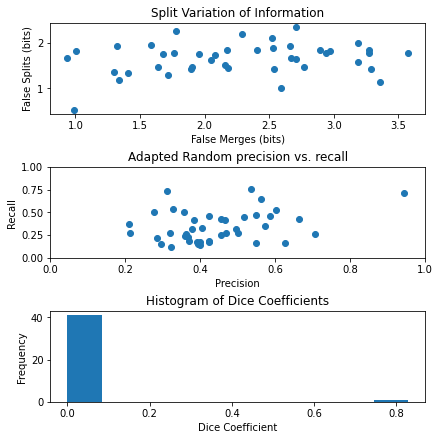

In [14]:
#========================================================#
# analyze results

# create figure
fig, axes = plt.subplots(3, 1, figsize=(6, 6), constrained_layout=True)
ax = axes.ravel()

# plot merges, splits
ax[0].scatter(merges_list, splits_list)
ax[0].set_xlabel('False Merges (bits)')
ax[0].set_ylabel('False Splits (bits)')
ax[0].set_title('Split Variation of Information')

# plot precision, recall
ax[1].scatter(precision_list, recall_list)
ax[1].set_xlabel('Precision')
ax[1].set_ylabel('Recall')
ax[1].set_title('Adapted Random precision vs. recall')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

# plot dice coefficients
ax[2].hist(dice_list)
ax[2].set_xlabel('Dice Coefficient')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Histogram of Dice Coefficients')

Based on the results, it appears that scikit-image is only able to fit to one specific image at a time, and therefore only the image with the palm tree had high accuracy values, whereas the other images did not. 

**Looking at a Poorly Segmented Example**

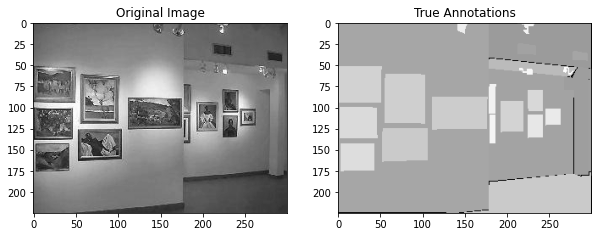

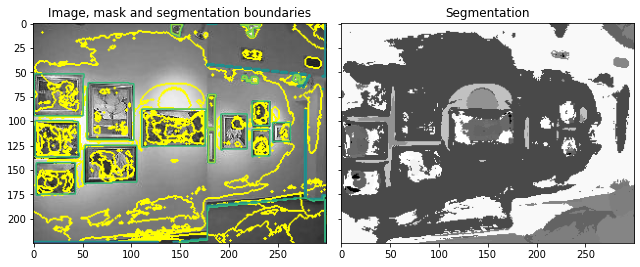

In [15]:
#========================================================#
# see low accuracy since had only trained on one image which has high dice coefficient

### original ###

# create figure
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,10)

# plot original image in left panel
ax[0].imshow(images_grey_match[1], cmap = plt.cm.gray)
ax[0].set_title("Original Image")

# plot labeled image in right panel
ax[1].imshow(labels_grey_match[1], cmap = plt.cm.gray)
ax[1].set_title("True Annotations")
plt.show()

### segmented ###

# create figure
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))

# plot original image with predicted outline in left panel
ax[0].imshow(segmentation.mark_boundaries(images_grey_match[1], result_list[1], mode='thick'))
ax[0].contour(labels_grey_match[1])
ax[0].set_title('Image, mask and segmentation boundaries')

# plot predicted annotations in right panel
ax[1].imshow(result_list[1], cmap = plt.cm.gray)
ax[1].set_title('Segmentation')
fig.tight_layout()

This thus presents an opportunity for Proglearn to allow for improved and more generalizable scene segmentation.

## III. Proglearn for Scene Segmentation

We next proceed to use the example of scikit-image to apply Proglearn for scene segmentation. We will use the LifelongClassificationForest in place of the RandomForestClassifier. Unfortunately, in doing so we come across the error of dimensionality. Proglearn as it is implemented now only takes in a 1D array for the class label, whereas the dataset ADE20K consists of labels per pixel. Therefore, more work will need to be done to accommodate this specific dataset. An alternative approach will be to use another dataset where the labels are binary and therefore the problem is more simplified before we scale up to a more complex situation like the ADE20K dataset. 

Ultimately, we hope to be able to use Proglearn and test our scene segmentation implementation using more than one task. 